In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [17]:


# Чтение данных
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('data/SN_ms_tot_V2.0.csv', delimiter=',', header=None, usecols=[0, 1, 3], names=['Year', 'Month', 'Sunspots'])

# Предобработка данных
data['Date'] = data['Year'] + (data['Month'] - 1) / 12
data = data[['Date', 'Sunspots']]
data = data[data['Sunspots'] >= 0]

scaler = MinMaxScaler()
data['Sunspots'] = scaler.fit_transform(data['Sunspots'].values.reshape(-1, 1))

# Создание временных рядов
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data[['Sunspots']], seq_length)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Конвертация в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Использование DataLoader для батчей
batch_size = 64
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

# Определение модели
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Инициализация модели, оптимизатора и функции потерь
model = LSTMModel().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:

# Обучение модели
epochs = 10
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    batch_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_loss += loss.item()
    
    train_losses.append(batch_train_loss / len(train_loader))
    
    model.eval()
    batch_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_test_pred = model(X_batch)
            loss = loss_function(y_test_pred, y_batch)
            batch_test_loss += loss.item()
    
    test_losses.append(batch_test_loss / len(test_loader))
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} Train Loss: {train_losses[-1]} Test Loss: {test_losses[-1]}')


Epoch 10 Train Loss: 0.0005341696334653534 Test Loss: 0.00042011247569462284


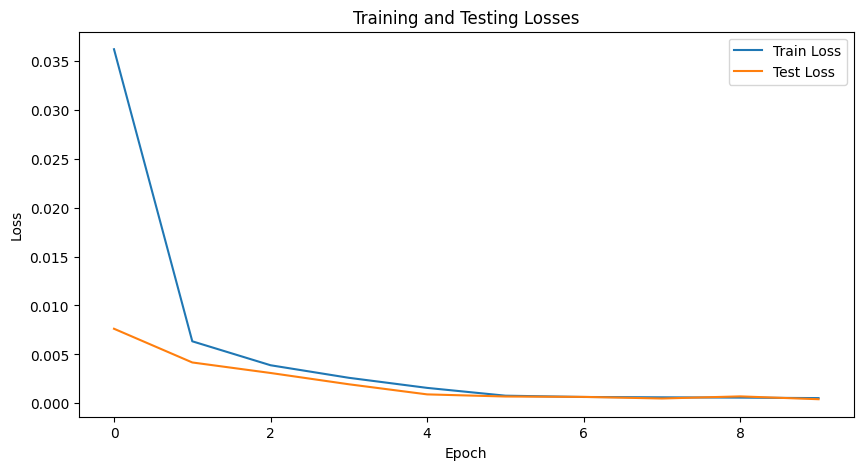

In [19]:

# Визуализация лосса
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses')
plt.show()


In [20]:
# Прогнозирование и визуализация результатов
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(device)).cpu().numpy()
    test_pred = model(X_test.to(device)).cpu().numpy()

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))


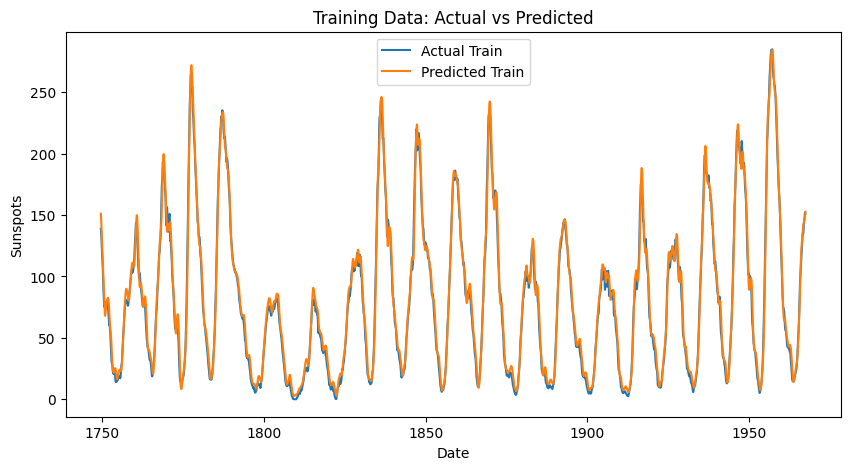

In [21]:
# Визуализация для тренировочной выборки
plt.figure(figsize=(10,5))
plt.plot(data['Date'][:len(train_pred)], y_train_inv, label='Actual Train')
plt.plot(data['Date'][:len(train_pred)], train_pred, label='Predicted Train')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.title('Training Data: Actual vs Predicted')
plt.show()


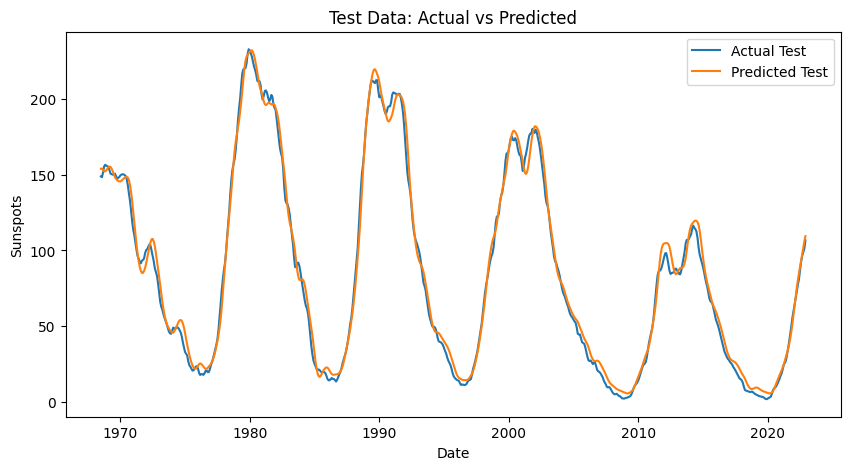

In [23]:
# Визуализация для тестовой выборки
plt.figure(figsize=(10,5))
plt.plot(data['Date'][-len(test_pred):], y_test_inv, label='Actual Test')
plt.plot(data['Date'][-len(test_pred):], test_pred, label='Predicted Test')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.title('Test Data: Actual vs Predicted')
plt.show()


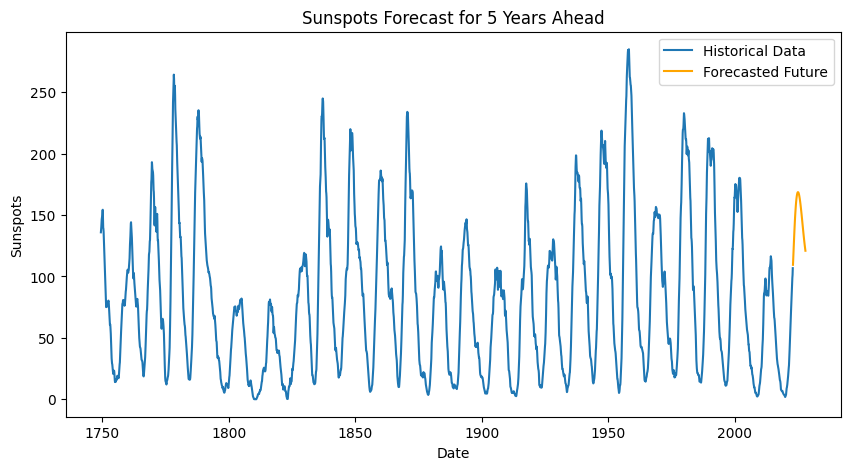

In [24]:
# Прогнозирование на 5 лет вперед
forecast_horizon = 5 * 12  # 5 лет в месяцах
last_sequence = X_test[-1:].cpu().numpy()  # Последняя последовательность из тестового набора
future_predictions = []

model.eval()
with torch.no_grad():
    for _ in range(forecast_horizon):
        input_seq = torch.tensor(last_sequence, dtype=torch.float32).to(device)
        future_pred = model(input_seq).cpu().numpy()
        future_predictions.append(future_pred[0, 0])
        # Обновление последней последовательности
        last_sequence = np.append(last_sequence[:, 1:, :], [[future_pred[0]]], axis=1)

# Преобразование прогнозов
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Добавление прогнозируемых дат
last_date = data['Date'].iloc[-1]
future_dates = [last_date + (i + 1) / 12 for i in range(forecast_horizon)]

# Визуализация прогноза
plt.figure(figsize=(10,5))
plt.plot(data['Date'], scaler.inverse_transform(data['Sunspots'].values.reshape(-1, 1)), label='Historical Data')
plt.plot(future_dates, future_predictions, label='Forecasted Future', color='orange')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.title('Sunspots Forecast for 5 Years Ahead')
plt.show()


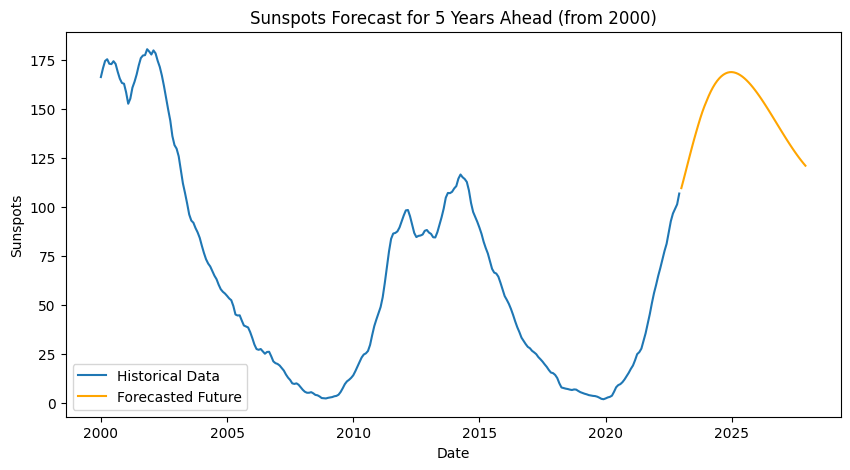

In [25]:
# Фильтрация данных с 2000 года
filtered_data = data[data['Date'] >= 2000]

# Визуализация прогноза начиная с 2000 года
plt.figure(figsize=(10,5))
plt.plot(filtered_data['Date'], scaler.inverse_transform(filtered_data['Sunspots'].values.reshape(-1, 1)), label='Historical Data')
plt.plot(future_dates, future_predictions, label='Forecasted Future', color='orange')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.title('Sunspots Forecast for 5 Years Ahead (from 2000)')
plt.show()
